# Data cleaning and Analysis

The goal of this task is to demonstrate end-to-end data wrangling, feature engineering, exploratory data analysis (EDA), and predictive modeling using a dataset of real estate properties. The key objectives are:

- Clean real estate listings data.
- Engineer useful features to support analysis and modeling.
- Explore trends, correlations, and pricing behavior across regions.
- Build regression models to predict property prices (in OMR).

In [43]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

## Cleaning bayut data 

In [44]:
import pandas as pd

BD = pd.read_csv('data/Bayutdata.csv')
BD.head()

,Title,Price,Bedrooms,Bathrooms,Area,Location,Property_Type,URL,Page
0,"2 Bedroom Apartment For Rent Muscat Hills, Muscat",OMR550,2.0,2.0,80 Sq. M.,"Muscat Hills, Muscat",Apartment,https://www.bayut.om/en/property/details-12863...,1
1,"4 Bedroom Villa For Rent Bosher, Muscat",OMR500,4.0,5.0,300 Sq. M.,"Bosher, Muscat",Villa,https://www.bayut.om/en/property/details-13026...,1
2,4 Bedrooms Villa For Rent Bosher - Muscat,OMR700,4.0,5.0,310 Sq. M.,"Bosher, Muscat",Villa,https://www.bayut.om/en/property/details-13001...,1
3,"2 Bedrooms Apartment For Rent Muscat Hills, Mu...",OMR550,2.0,3.0,120 Sq. M.,"Muscat Hills, Muscat",Apartment,https://www.bayut.om/en/property/details-13026...,1
4,"3 Bedrooms Apartment For Rent Azaiba, Muscat",OMR400,3.0,1.0,80 Sq. M.,"Azaiba, Muscat",Apartment,https://www.bayut.om/en/property/details-13001...,1


In [45]:
# we will get rid of page and url 

BD.drop(['Page', 'URL'], axis=1, inplace=True)
print(BD.columns)

Index(['Title', 'Price', 'Bedrooms', 'Bathrooms', 'Area', 'Location',
       'Property_Type'],
      dtype='object')


### Cleaning

In [46]:
import pandas as pd
import numpy as np

def clean_Bayut(BD, output_file='cleanedBD.csv'):
    try:
        # Make a copy to avoid modifying original
        df = BD.copy()
        print("Original data shape:", df.shape)
        
        # Clean the Price column
        if 'Price' in df.columns:
            df['Price'] = (
                df['Price']
                .astype(str)
                .str.replace(r'[^\d.]', '', regex=True)  # Remove non-digit characters except decimal
                .replace('', np.nan)
            )
            df['Price'] = pd.to_numeric(df['Price'])
            print("\nPrice column cleaned (examples):")
            print(df['Price'].head())
        
        # Handle missing values 
        print("\nMissing value handling:")
        
        # Fill Location with mode
        if 'Location' in df.columns:
            location_mode = df['Location'].mode()[0] if not df['Location'].mode().empty else 'Unknown'
            df['Location'] = df['Location'].fillna(location_mode)
            print(f"Location values filled with mode: {location_mode}")
            
        # Process numeric columns (bedrooms, bathrooms)
        for col in ['bedrooms', 'bathrooms']:
            if col in df.columns:
                # Extract numbers and convert to float first
                df[col] = df[col].astype(str).str.extract(r'(\d+)')[0].astype(float)
                # Calculate mean (skip NaN values)
                col_mean = df[col].mean(skipna=True)
                # Fill NA with mean and convert to INTEGER
                df[col] = df[col].fillna(col_mean).astype('int64')
                print(f"Filled {col} nulls with mean: {col_mean:.0f} (converted to int)")

        # we delete last row  
        df = df.iloc[:-1]

        
        # Final verification 
        print("\nFinal data summary:")
        print(df.isnull().sum())
        
        # Save the cleaned data 
        df.to_csv(output_file, index=False)
        print(f"\nSaved cleaned data to {output_file}")
        print("Final shape:", df.shape)
           
        return df
        
    except Exception as e:
        print(f"\nError during cleaning: {str(e)}")
        return None


# Run the cleaning only if BD exists
if 'BD' in locals():
    print("--- Starting Cleaning ---")
    cleaned_data = clean_Bayut(BD)
    if cleaned_data is not None:
        print("\nCleaned Data Preview:")
        display(cleaned_data.head(3))
    else:
        print("Cleaning failed")
else:
    print("Error: BD DataFrame not found")

--- Starting Cleaning ---
Original data shape: (1028, 7)

Price column cleaned (examples):
0    550
1    500
2    700
3    550
4    400
Name: Price, dtype: int64

Missing value handling:
Location values filled with mode: Qurum, Muscat

Final data summary:
Title             0
Price             0
Bedrooms         16
Bathrooms        15
Area              0
Location          0
Property_Type     0
dtype: int64

Saved cleaned data to cleanedBD.csv
Final shape: (1027, 7)

Cleaned Data Preview:


,Title,Price,Bedrooms,Bathrooms,Area,Location,Property_Type
0,"2 Bedroom Apartment For Rent Muscat Hills, Muscat",550,2.0,2.0,80 Sq. M.,"Muscat Hills, Muscat",Apartment
1,"4 Bedroom Villa For Rent Bosher, Muscat",500,4.0,5.0,300 Sq. M.,"Bosher, Muscat",Villa
2,4 Bedrooms Villa For Rent Bosher - Muscat,700,4.0,5.0,310 Sq. M.,"Bosher, Muscat",Villa


In [47]:
cleaned_data

,Title,Price,Bedrooms,Bathrooms,Area,Location,Property_Type
0,"2 Bedroom Apartment For Rent Muscat Hills, Muscat",550,2.0,2.0,80 Sq. M.,"Muscat Hills, Muscat",Apartment
1,"4 Bedroom Villa For Rent Bosher, Muscat",500,4.0,5.0,300 Sq. M.,"Bosher, Muscat",Villa
2,4 Bedrooms Villa For Rent Bosher - Muscat,700,4.0,5.0,310 Sq. M.,"Bosher, Muscat",Villa
3,"2 Bedrooms Apartment For Rent Muscat Hills, Mu...",550,2.0,3.0,120 Sq. M.,"Muscat Hills, Muscat",Apartment
4,"3 Bedrooms Apartment For Rent Azaiba, Muscat",400,3.0,1.0,80 Sq. M.,"Azaiba, Muscat",Apartment
...,...,...,...,...,...,...,...
1022,"2 Bedrooms Apartment For Rent Al Ghubrah, Muscat",210,2.0,2.0,70 Sq. M.,"Al Ghubrah, Muscat",Apartment
1023,3 Bedrooms Apartment For Rent Al Wadi Al Kabir...,130,3.0,2.0,150 Sq. M.,"Al Wadi Al Kabir, Muscat",Apartment
1024,"2 Bedroom Apartment For Rent in Al Khuwair, Mu...",300,2.0,3.0,110 Sq. M.,"Al Khuwair, Muscat",Apartment
1025,4 Bedroom Villa For Rent Madinat As Sultan Qab...,725,4.0,5.0,250 Sq. M.,"Qurum, Muscat",Villa


### Clean Dubizzle data

In [48]:
import pandas as pd

DUB = pd.read_csv('data/Dubdatat.csv')
DUB.head()

,title,url,price_omr,bedrooms,bathrooms,size_sqm,locality,listing_date,agency
0,شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...,https://www.dubizzle.com.om/en/ad/%D8%B4%D9%82...,46000.0,2.0,3.0,102.0,"Ghala, Muscat",5 hours ago,* يقع المشروع في مرتفعات غلا بجانب شركة الغاز ...
1,1 BHK Apartment for Sale in Muscat - Yiti – شق...,https://www.dubizzle.com.om/en/ad/1-bhk-apartm...,87000.0,1.0,2.0,79.0,"Yiti, Muscat",6 hours ago,شقق ذكية ومستدامة للبيع في المدينة المستدامة –...
2,Furnished 3-Bedroom Lakefront Villa for Sale i...,https://www.dubizzle.com.om/en/ad/furnished-3-...,244000.0,3.0,3.0,573.0,"Salalah, Dhofar",7 hours ago,Private Pool | Garden | Stunning Lake View | G...
3,Exclusive Furnished 3-Bedroom Villa for Sale i...,https://www.dubizzle.com.om/en/ad/exclusive-fu...,249000.0,3.0,3.0,610.0,"Salalah, Dhofar",7 hours ago,NaN
4,ارخص فیلا قید الانشاء | تقسیط | موج مسقط | 5 غ...,https://www.dubizzle.com.om/en/ad/%D8%A7%D8%B1...,573300.0,5.0,6.0,549.0,"The Wave (Almouj), Muscat",7 hours ago,NaN


In [49]:
# drop irrelavant columns
columns_to_drop = ['listing_date', 'agency', 'url']
DUB = DUB.drop(columns=[col for col in columns_to_drop if col in DUB.columns], errors='ignore')

In [50]:
# rename colomns to both datasets have matching column names
column_mapping = {
    'price_omr': 'Price',
    'locality': 'Location',
    'size_sqm': 'Size'
}
DUB = DUB.rename(columns=column_mapping)

In [51]:
# 1. Extract Property Type from Title
def extract_property_type(title):
    if pd.isna(title):
        return 'Unknown'
    
    title = str(title).lower()
    
    # Common property type keywords
    property_types = {
        'apartment': ['apartment', 'apt', 'flat'],
        'villa': ['villa', 'house'],
        'penthouse': ['penthouse'],
        'studio': ['studio'],
        'townhouse': ['townhouse', 'town house'],
        'land': ['land', 'plot'],
        'commercial': ['office', 'shop', 'retail', 'commercial']
    }
    
    for prop_type, keywords in property_types.items():
        if any(keyword in title for keyword in keywords):
            return prop_type.title()
    
    return 'Other'

# Apply to create new column
DUB['Property_type'] = DUB['title'].apply(extract_property_type)

# 2. Clean numeric columns
for col in ['Price', 'bedrooms', 'bathrooms']:
    if col in DUB.columns:
        # Convert to string, extract numbers, convert to numeric
        DUB[col] = DUB[col].astype(str).str.extract(r'(\d+\.?\d*)')[0]
        DUB[col] = pd.to_numeric(DUB[col], errors='coerce')
        
        # Fill missing values with mean for numeric columns
        if col in ['bedrooms', 'bathrooms']:
            col_mean = DUB[col].mean()
            DUB[col] = DUB[col].fillna(col_mean).astype('int64')
            print(f"Filled {col} nulls with mean: {col_mean:.0f}")

# 3. Clean Size column if exists
if 'Size' in DUB.columns:
    DUB['Size'] = DUB['Size'].astype(str).str.extract(r'(\d+)')[0]
    DUB['Size'] = pd.to_numeric(DUB['Size'], errors='coerce')

# 4. Clean Location
if 'Location' in DUB.columns:
    DUB['Location'] = DUB['Location'].str.strip().str.title()
    location_mode = DUB['Location'].mode()[0]
    DUB['Location'] = DUB['Location'].fillna(location_mode)
    print(f"Filled Location nulls with mode: {location_mode}")

# 5. Remove duplicates and empty rows
initial_rows = len(DUB)
DUB = DUB.dropna(subset=['title', 'Price']).drop_duplicates()
print(f"Removed {initial_rows - len(DUB)} rows (duplicates or missing data)")

# 6. Final verification
print("\nProperty Type Distribution:")
print(DUB['Property_type'].value_counts(dropna=False))
print("\nFinal columns:", DUB.columns.tolist())
print("Data shape:", DUB.shape)
print("\nSample data with Property_type:")
print(DUB[['title', 'Property_type', 'Price', 'bedrooms', 'bathrooms']].head(3))

Filled bedrooms nulls with mean: 3
Filled bathrooms nulls with mean: 4
Filled Location nulls with mode: The Wave (Almouj), Muscat
Removed 590 rows (duplicates or missing data)

Property Type Distribution:
Property_type
Villa         786
Apartment     741
Other         587
Commercial    346
Studio         43
Land           12
Name: count, dtype: int64

Final columns: ['title', 'Price', 'bedrooms', 'bathrooms', 'Size', 'Location', 'Property_type']
Data shape: (2515, 7)

Sample data with Property_type:
                                               title Property_type     Price  \
0  شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...         Other   46000.0   
1  1 BHK Apartment for Sale in Muscat - Yiti – شق...     Apartment   87000.0   
2  Furnished 3-Bedroom Lakefront Villa for Sale i...         Villa  244000.0   

   bedrooms  bathrooms  
0         2          3  
1         1          2  
2         3          3  


In [52]:
DUB

,title,Price,bedrooms,bathrooms,Size,Location,Property_type
0,شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...,46000.0,2,3,102.0,"Ghala, Muscat",Other
1,1 BHK Apartment for Sale in Muscat - Yiti – شق...,87000.0,1,2,79.0,"Yiti, Muscat",Apartment
2,Furnished 3-Bedroom Lakefront Villa for Sale i...,244000.0,3,3,573.0,"Salalah, Dhofar",Villa
3,Exclusive Furnished 3-Bedroom Villa for Sale i...,249000.0,3,3,610.0,"Salalah, Dhofar",Villa
4,ارخص فیلا قید الانشاء | تقسیط | موج مسقط | 5 غ...,573300.0,5,6,549.0,"The Wave (Almouj), Muscat",Other
...,...,...,...,...,...,...,...
3100,فلة راقیة/4غرف نوم /موج مسقط Luxurious villas/...,355000.0,4,4,465.0,"The Wave (Almouj), Muscat",Villa
3101,1 BR Impressive Spacious Apartment in Muscat H...,330.0,1,1,63.0,"Muscat Hills, Muscat",Apartment
3102,highly recommend 5+1 Bhk villa row community i...,1250.0,5,6,550.0,"Madinat As Sultan Qaboos, Muscat",Villa
3103,بیع عاجل/فیلا راقیه 6غرف نوم/luxury villa for ...,470000.0,6,7,588.0,"The Wave (Almouj), Muscat",Villa


In [53]:
output_filename = 'clean_data/dubclean.csv'
DUB.to_csv(output_filename, index=False, encoding='utf-8')

# Merging both Datasets

In [54]:
# lets Load both CSV files
df_dubai = pd.read_csv('clean_data/dubclean.csv')
df_bayut = pd.read_csv('clean_data/cleanedBD.csv')

# Verify column alignment 
print("Dubai columns:", df_dubai.columns.tolist())
print("Bayut columns:", df_bayut.columns.tolist())

# make sure all columns are the same 
df_bayut.columns = df_bayut.columns.str.lower()
df_dubai.columns = df_dubai.columns.str.lower()

# Concatenate the datasets 
combined = pd.concat([df_dubai, df_bayut], 
                    axis=0,          # Stack vertically
                    ignore_index=True) # Reset index

# a5er tan6eef
# Convert numeric columns
numeric_cols = ['Price', 'bedrooms', 'bathrooms', 'Size']
for col in numeric_cols:
    if col in combined.columns:
        combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Fill remaining missing values
if 'Location' in combined.columns:
    combined['Location'] = combined['Location'].fillna('Unknown')

# Remove exact duplicates
combined = combined.drop_duplicates()

# Save merged data  
combined.to_csv('combined_properties_ARWA.csv', index=False)

# 7. Results verification
print("\n=== Merge Results ===")
print(f"Total properties: {len(combined):,}")
print(f"Dub properties: {len(df_dubai):,}")
print(f"Bayut properties: {len(df_bayut):,}")
print("\nFirst 3 combined records:")
print(combined.head(3))
print("\nSaved to: combined_properties_final.csv")

Dubai columns: ['title', 'Price', 'bedrooms', 'bathrooms', 'Size', 'Location', 'Property_type']
Bayut columns: ['Title', 'Price', 'Bedrooms', 'Bathrooms', 'Area', 'Location', 'Property_Type']

=== Merge Results ===
Total properties: 3,502
Dub properties: 2,515
Bayut properties: 1,026

First 3 combined records:
                                               title     price  bedrooms  \
0  شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...   46000.0       2.0   
1  1 BHK Apartment for Sale in Muscat - Yiti – شق...   87000.0       1.0   
2  Furnished 3-Bedroom Lakefront Villa for Sale i...  244000.0       3.0   

   bathrooms   size         location property_type area  
0        3.0  102.0    Ghala, Muscat         Other  NaN  
1        2.0   79.0     Yiti, Muscat     Apartment  NaN  
2        3.0  573.0  Salalah, Dhofar         Villa  NaN  

Saved to: combined_properties_final.csv


In [55]:
combined.head(10) # just checking

,title,price,bedrooms,bathrooms,size,location,property_type,area
0,شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...,46000.0,2.0,3.0,102.0,"Ghala, Muscat",Other,NaN
1,1 BHK Apartment for Sale in Muscat - Yiti – شق...,87000.0,1.0,2.0,79.0,"Yiti, Muscat",Apartment,NaN
2,Furnished 3-Bedroom Lakefront Villa for Sale i...,244000.0,3.0,3.0,573.0,"Salalah, Dhofar",Villa,NaN
3,Exclusive Furnished 3-Bedroom Villa for Sale i...,249000.0,3.0,3.0,610.0,"Salalah, Dhofar",Villa,NaN
4,ارخص فیلا قید الانشاء | تقسیط | موج مسقط | 5 غ...,573300.0,5.0,6.0,549.0,"The Wave (Almouj), Muscat",Other,NaN
5,MADINAT AL ILAM | EXCELLENT 4+1 BR TOWNHOUSE,650.0,4.0,6.0,300.0,"Madinat As Sultan Qaboos, Muscat",Villa,NaN
6,AL KHUWAIR | WELL MAINTAINED 2 BHK FLAT,280.0,2.0,2.0,105.0,"Al Khuwair, Muscat",Apartment,NaN
7,"Luxury Sea View Apartment for Sale – Juman 2, ...",215000.0,2.0,3.0,145.0,"The Wave (Almouj), Muscat",Apartment,NaN
8,Elegant 4 BHK Villa for rent @ Qurum,650.0,4.0,5.0,300.0,"Qurum, Muscat",Villa,NaN
9,ANSAB | 8 BEDROOM VILLA,400.0,8.0,9.0,300.0,"Ansab, Muscat",Villa,NaN


## Exploratory Data Analysis (EDA) 

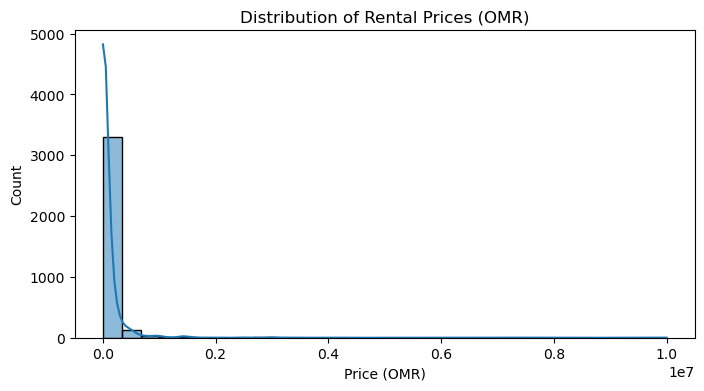

In [56]:
# Distribution of price
plt.figure(figsize=(8,4))
sns.histplot(combined['price'], bins=30, kde=True)
plt.title("Distribution of Rental Prices (OMR)")
plt.xlabel("Price (OMR)")
plt.ylabel("Count")
plt.show()

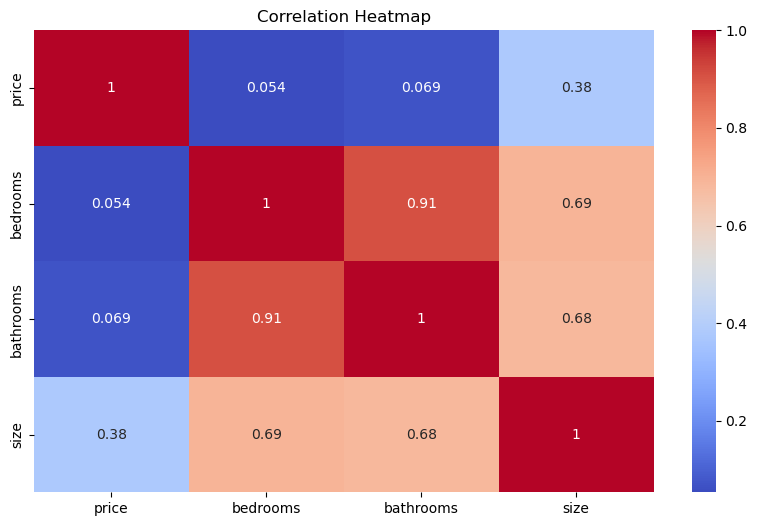

In [57]:
# Correlation heatmap
numeric_cols = combined.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10,6))
sns.heatmap(combined[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

##  Feature Engineering

To improve model performance, we create new features and transform existing ones. This includes:

- Total number of rooms
- Price per square meter
- Encoding categorical variables
- Scaling numerical features

These steps help the model better understand patterns and reduce bias from raw input values.

In [58]:
combined['total_rooms'] = combined['bedrooms'] + combined['bathrooms']
combined['price_per_sqm'] = combined['price'] / combined['size']

In [59]:
# Fill any inf or NaN from division
combined['price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
combined['price_per_sqm'].fillna(combined['price_per_sqm'].median(), inplace=True)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_32576\3900625934.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\bbuser\AppData\Local\Temp\ipykernel_32576\3900625934.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [60]:
combined.head(10)

,title,price,bedrooms,bathrooms,size,location,property_type,area,total_rooms,price_per_sqm
0,شقة للبيع بمواصفات مميزة وبجودة ممتازة فرصة را...,46000.0,2.0,3.0,102.0,"Ghala, Muscat",Other,NaN,5.0,450.980392
1,1 BHK Apartment for Sale in Muscat - Yiti – شق...,87000.0,1.0,2.0,79.0,"Yiti, Muscat",Apartment,NaN,3.0,1101.265823
2,Furnished 3-Bedroom Lakefront Villa for Sale i...,244000.0,3.0,3.0,573.0,"Salalah, Dhofar",Villa,NaN,6.0,425.828970
3,Exclusive Furnished 3-Bedroom Villa for Sale i...,249000.0,3.0,3.0,610.0,"Salalah, Dhofar",Villa,NaN,6.0,408.196721
4,ارخص فیلا قید الانشاء | تقسیط | موج مسقط | 5 غ...,573300.0,5.0,6.0,549.0,"The Wave (Almouj), Muscat",Other,NaN,11.0,1044.262295
5,MADINAT AL ILAM | EXCELLENT 4+1 BR TOWNHOUSE,650.0,4.0,6.0,300.0,"Madinat As Sultan Qaboos, Muscat",Villa,NaN,10.0,2.166667
6,AL KHUWAIR | WELL MAINTAINED 2 BHK FLAT,280.0,2.0,2.0,105.0,"Al Khuwair, Muscat",Apartment,NaN,4.0,2.666667
7,"Luxury Sea View Apartment for Sale – Juman 2, ...",215000.0,2.0,3.0,145.0,"The Wave (Almouj), Muscat",Apartment,NaN,5.0,1482.758621
8,Elegant 4 BHK Villa for rent @ Qurum,650.0,4.0,5.0,300.0,"Qurum, Muscat",Villa,NaN,9.0,2.166667
9,ANSAB | 8 BEDROOM VILLA,400.0,8.0,9.0,300.0,"Ansab, Muscat",Villa,NaN,17.0,1.333333


# Modeling

##  Predictive Modeling

The objective here is to build regression models to predict the target variable: **`price_omr`**.

We will:

- Split the dataset into training and test sets
- Use `StandardScaler` and `OneHotEncoder` for preprocessing
- Train and evaluate three models:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
- Measure performance using:
  - RMSE (Root Mean Squared Error)
  - R² Score (Coefficient of Determination)


In [102]:
combined = combined.loc[:, ~combined.columns.duplicated(keep='first')]

feature_cols = [
    'size',
    'bedrooms',
    'bathrooms',
    'total_rooms',
    'price',
]

X = combined[feature_cols]
y = combined['price']

In [103]:
# Preprocessing pipeline
numeric_features = ['bedrooms', 'bathrooms','total_rooms','size']
categorical_features = ['price']

In [104]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [105]:
# Models to train
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [106]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Train and evaluate
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor',    model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"  RMSE:    {rmse:.2f}")
    print(f"  R² Score:{r2:.2f}\n")

    # i give up, will fix it later

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# will ignore an nan values unlike the one above 

# 1) split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) drop any rows with missing in those columns
X_train_clean = X_train.dropna(subset=numeric_features + categorical_features)
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean  = X_test .dropna(subset=numeric_features + categorical_features)
y_test_clean  = y_test .loc[ X_test_clean.index]

# 3) now build & fit your pipelines on the _clean_ sets
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor',     model)
    ])
    pipeline.fit( X_train_clean, y_train_clean )
    y_pred = pipeline.predict( X_test_clean )
    rmse   = np.sqrt(mean_squared_error(y_test_clean, y_pred))
    print(f"{name:15s} → RMSE: {rmse:.2f}")


Linear Regression → RMSE: 94363.51
Decision Tree   → RMSE: 157628.56
Random Forest   → RMSE: 128782.04


###  Final Note:

This project was completed in just two days and remains a work in progress. Much more development is required, and many challenges lie ahead.
Although guidelines advised against external assistance, the reality is that under tight deadlines and pressure, collaboration becomes essential.
Colleagues and online resources provided invaluable support, and this code reflects what I was able to achieve with their help.